# Logistic Regression: Diabetes Binary Classification

### PA Women in Tech: Intro to Data Science with Python

### Import Packages

In [259]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

sns.set_style("dark")

### Data Exploration

The diabetes CSV file was read into a dataframe using Pandas.

In [260]:
df = pd.read_csv("diabetes.csv")
df

,id,chol,stab.glu,hdl,ratio,glyhb,age,gender,height,weight,frame,bp.1s,bp.1d,waist,hip
0,1000,203.0,82,56.0,3.6,4.310000,46,female,62.0,121.0,medium,118.0,59.0,29.0,38.0
1,1001,165.0,97,24.0,6.9,4.440000,29,female,64.0,218.0,large,112.0,68.0,46.0,48.0
2,1002,228.0,92,37.0,6.2,4.640000,58,female,61.0,256.0,large,190.0,92.0,49.0,57.0
3,1003,78.0,93,12.0,6.5,4.630000,67,male,67.0,119.0,large,110.0,50.0,33.0,38.0
4,1005,249.0,90,28.0,8.9,7.720000,64,male,68.0,183.0,medium,138.0,80.0,44.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,41506,296.0,369,46.0,6.4,16.110001,53,male,69.0,173.0,medium,138.0,94.0,35.0,39.0
399,41507,284.0,89,54.0,5.3,4.390000,51,female,63.0,154.0,medium,140.0,100.0,32.0,43.0
400,41510,194.0,269,38.0,5.1,13.630000,29,female,69.0,167.0,small,120.0,70.0,33.0,40.0
401,41752,199.0,76,52.0,3.8,4.490000,41,female,63.0,197.0,medium,120.0,78.0,41.0,48.0


The missing value count per column was displayed for an overview of how complete the dataset was.

In [261]:
df.isnull().sum().to_frame("null count")

,null count
id,0
chol,1
stab.glu,0
hdl,1
ratio,1
glyhb,13
age,0
gender,0
height,5
weight,1


To calculate the correlation between columns the categorial fields `frame` and `gender` were dropped as well as the `id` column which has is purely a unique identifier per patient. The missing numerical values were replaced with the mean of the remaining values as an estimate.

In [262]:
# Drop columns
df_num_only = df.drop(labels=["id", "frame", "gender"],  axis=1)

# Get all column names with no value
na_col_names = df_num_only.columns[df_num_only.isna().any()].tolist()

# Replace each column with no value with the mean of the other values
for name in na_col_names:
  df_num_only[name] = df_num_only[name].fillna(df_num_only[name].mean())

df_num_only.isnull().sum().to_frame("null count")


,null count
chol,0
stab.glu,0
hdl,0
ratio,0
glyhb,0
age,0
height,0
weight,0
bp.1s,0
bp.1d,0


The correlation matrix can now be calculated and visualized.

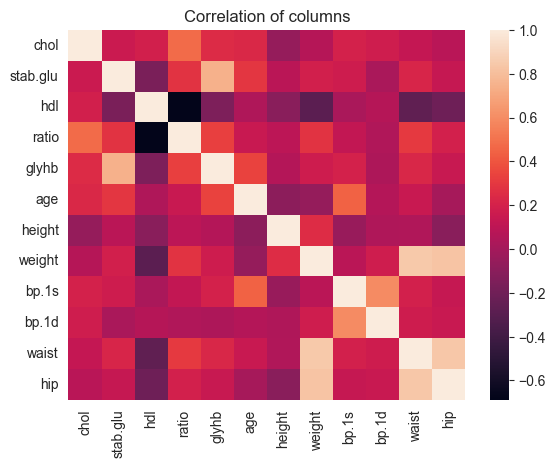

In [263]:
corr = df_num_only.corr()
sns.heatmap(corr)
plt.title("Correlation of columns")
plt.show()

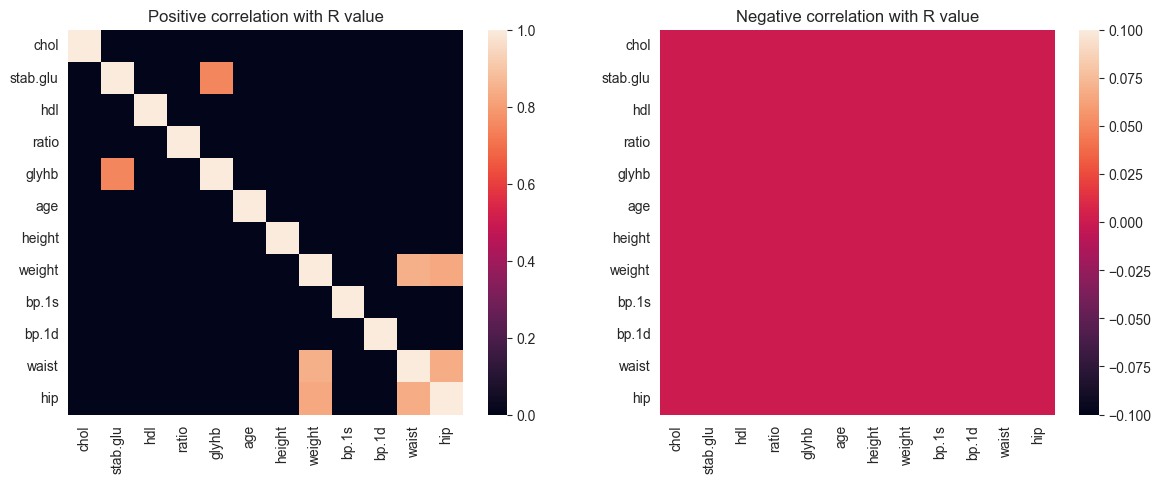

In [264]:
r = 0.7

fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].set_title("Positive correlation with R value")
axs[1].set_title("Negative correlation with R value")
sns.heatmap(corr.map(lambda x: x if x > r else 0), ax=axs[0])
sns.heatmap(corr.map(lambda x: x if x < -r else 0), ax=axs[1])
plt.show()

Having set the correlation relationship (r value) to be `0.7`, the strongest positive correlations, ignoring trivial identity correlations along the diagonal are with `weight`, `waist` and `hip` and with `stab.glu` and `glyhb`. The strong negative correlations were also checked yielding no results.

For better feature engineering I also calculated the waist to hip ratio (`whr`) and the body mass index (`bmi`) and included them 

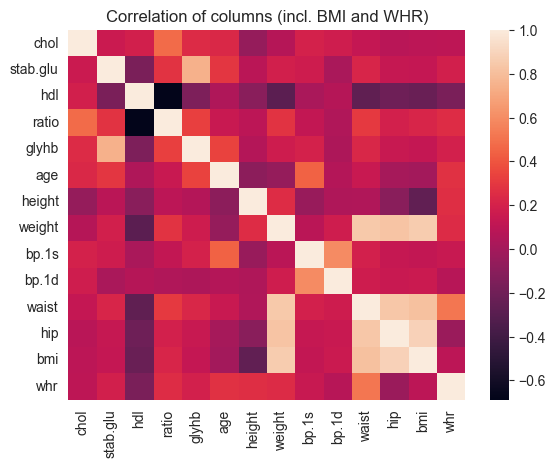

In [265]:
# BMI = (weight in pounds x 703) / (height in inches)^2
bmi = ((df_num_only["weight"] * 703) / (df_num_only["height"] ** 2)).to_frame("bmi")

# WHR = waist circumference / hip circumference
whr = (df_num_only["waist"] / df_num_only["hip"]).to_frame("whr")

df_extra = df_num_only.join(bmi).join(whr)

sns.heatmap(df_extra.corr())
plt.title("Correlation of columns (incl. BMI and WHR)")
plt.show()

### Data pre-processing

I used a data pipeline to chain a series of operations on the data to fill missing values, create new columns and one hot encode the categorical variables.

The numeric and categorical column names were intialized as these would be processed separately. The `id` was ommitted as it  is an patient independent statistic.

In [266]:
num_cols = ["chol", "stab.glu", "hdl", "ratio", "glyhb", "age", "height", "weight", "bp.1s", "bp.1d", "waist", "hip"]
cat_cols = ["gender", "frame"]

To add extra columns for `bmi` and `whr` [this link](https://towardsdatascience.com/clean-efficient-data-pipelines-with-pythons-sklearn-2472de04c0ea) was used to create a class to add them in the pipeline.

In [267]:
height_idx = 6
weight_idx = 7
waist_idx = 10
hip_idx = 11
class BMIAndWHRAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        bmi = (X[:,height_idx] * 703) / (X[:,weight_idx] ** 2)
        whr = X[:,waist_idx] / X[:,hip_idx]
        return np.c_[X, bmi, whr]

The pipeline for the numeric values was created using firstly `SimpleImputer` to replace the missing values with the median, and then the `BMIAndWHRAdder` class to add new columns.

The final pipeline can be created by combining the numerical pipeline with the categorical pipeline which uses `OneHotEncoder` to encode the categories.

The final result can have its columns added back by defining and including `bmi` and `whr` and the one hot encoded categories. 

In [268]:
cat_ohe = ["gender_female", "gender_male", "frame_large", "frame_medium", "frame_small", "frame_none"]
proc_cols = num_cols + ["bmi", "whr"] + cat_ohe

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('add_variables', BMIAndWHRAdder()),
])

data_pipeline = data_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_cols),
    ('categorical', OneHotEncoder(), cat_cols),
])

df_pre = pd.DataFrame(data=data_pipeline.fit_transform(df), columns=proc_cols)
df_pre


,chol,stab.glu,hdl,ratio,glyhb,age,height,weight,bp.1s,bp.1d,waist,hip,bmi,whr,gender_female,gender_male,frame_large,frame_medium,frame_small,frame_none
0,203.0,82.0,56.0,3.6,4.310000,46.0,62.0,121.0,118.0,59.0,29.0,38.0,2.976982,0.763158,1.0,0.0,0.0,1.0,0.0,0.0
1,165.0,97.0,24.0,6.9,4.440000,29.0,64.0,218.0,112.0,68.0,46.0,48.0,0.946722,0.958333,1.0,0.0,1.0,0.0,0.0,0.0
2,228.0,92.0,37.0,6.2,4.640000,58.0,61.0,256.0,190.0,92.0,49.0,57.0,0.654343,0.859649,1.0,0.0,1.0,0.0,0.0,0.0
3,78.0,93.0,12.0,6.5,4.630000,67.0,67.0,119.0,110.0,50.0,33.0,38.0,3.326107,0.868421,0.0,1.0,1.0,0.0,0.0,0.0
4,249.0,90.0,28.0,8.9,7.720000,64.0,68.0,183.0,138.0,80.0,44.0,41.0,1.427454,1.073171,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,296.0,369.0,46.0,6.4,16.110001,53.0,69.0,173.0,138.0,94.0,35.0,39.0,1.620736,0.897436,0.0,1.0,0.0,1.0,0.0,0.0
399,284.0,89.0,54.0,5.3,4.390000,51.0,63.0,154.0,140.0,100.0,32.0,43.0,1.867473,0.744186,1.0,0.0,0.0,1.0,0.0,0.0
400,194.0,269.0,38.0,5.1,13.630000,29.0,69.0,167.0,120.0,70.0,33.0,40.0,1.739288,0.825000,1.0,0.0,0.0,0.0,1.0,0.0
401,199.0,76.0,52.0,3.8,4.490000,41.0,63.0,197.0,120.0,78.0,41.0,48.0,1.141204,0.854167,1.0,0.0,0.0,1.0,0.0,0.0


This final preprocessed data correlations can be visualized below.

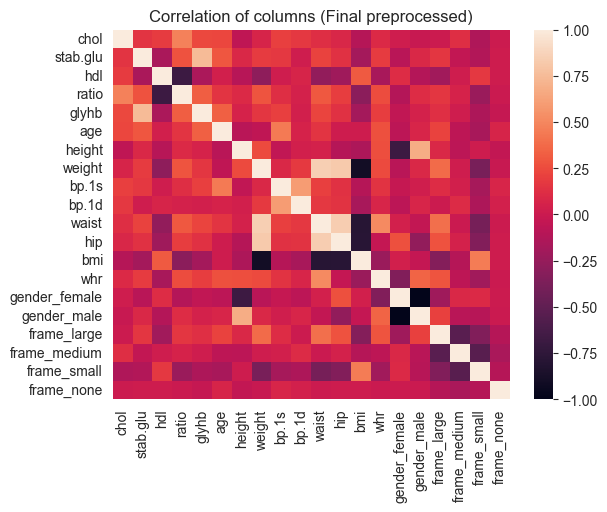

In [269]:
corr = df_pre.corr()
sns.heatmap(corr)
plt.title("Correlation of columns (Final preprocessed)")
plt.show()

The `glyhb` column was dropped since it will be used to test if the patient has diabetes in the output column. For the expected output data the  `glyhb` value will be checked to be greater than `6.5` which indicates that the patient has diabetes.

Afterwards, I split the data into training and testing sets (`2/3` training `1/3` testing).

In [270]:
features = ["chol", "stab.glu", "hdl", "ratio", "age", "height", "weight", "bp.1s", "bp.1d", "waist", "hip", "bmi", "whr", "gender_female", "gender_male", "frame_large", "frame_medium", "frame_small"]

X = df_pre[features]
y = df_pre["glyhb"].map(lambda x: 1 if x > 6.5 else 0).to_frame("diabetes")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Regression Model

The model used for this task is logistic regression. To better see each feature"s impact they were individually plotted using logistic regression to visualize any impact they would have on the outcome.

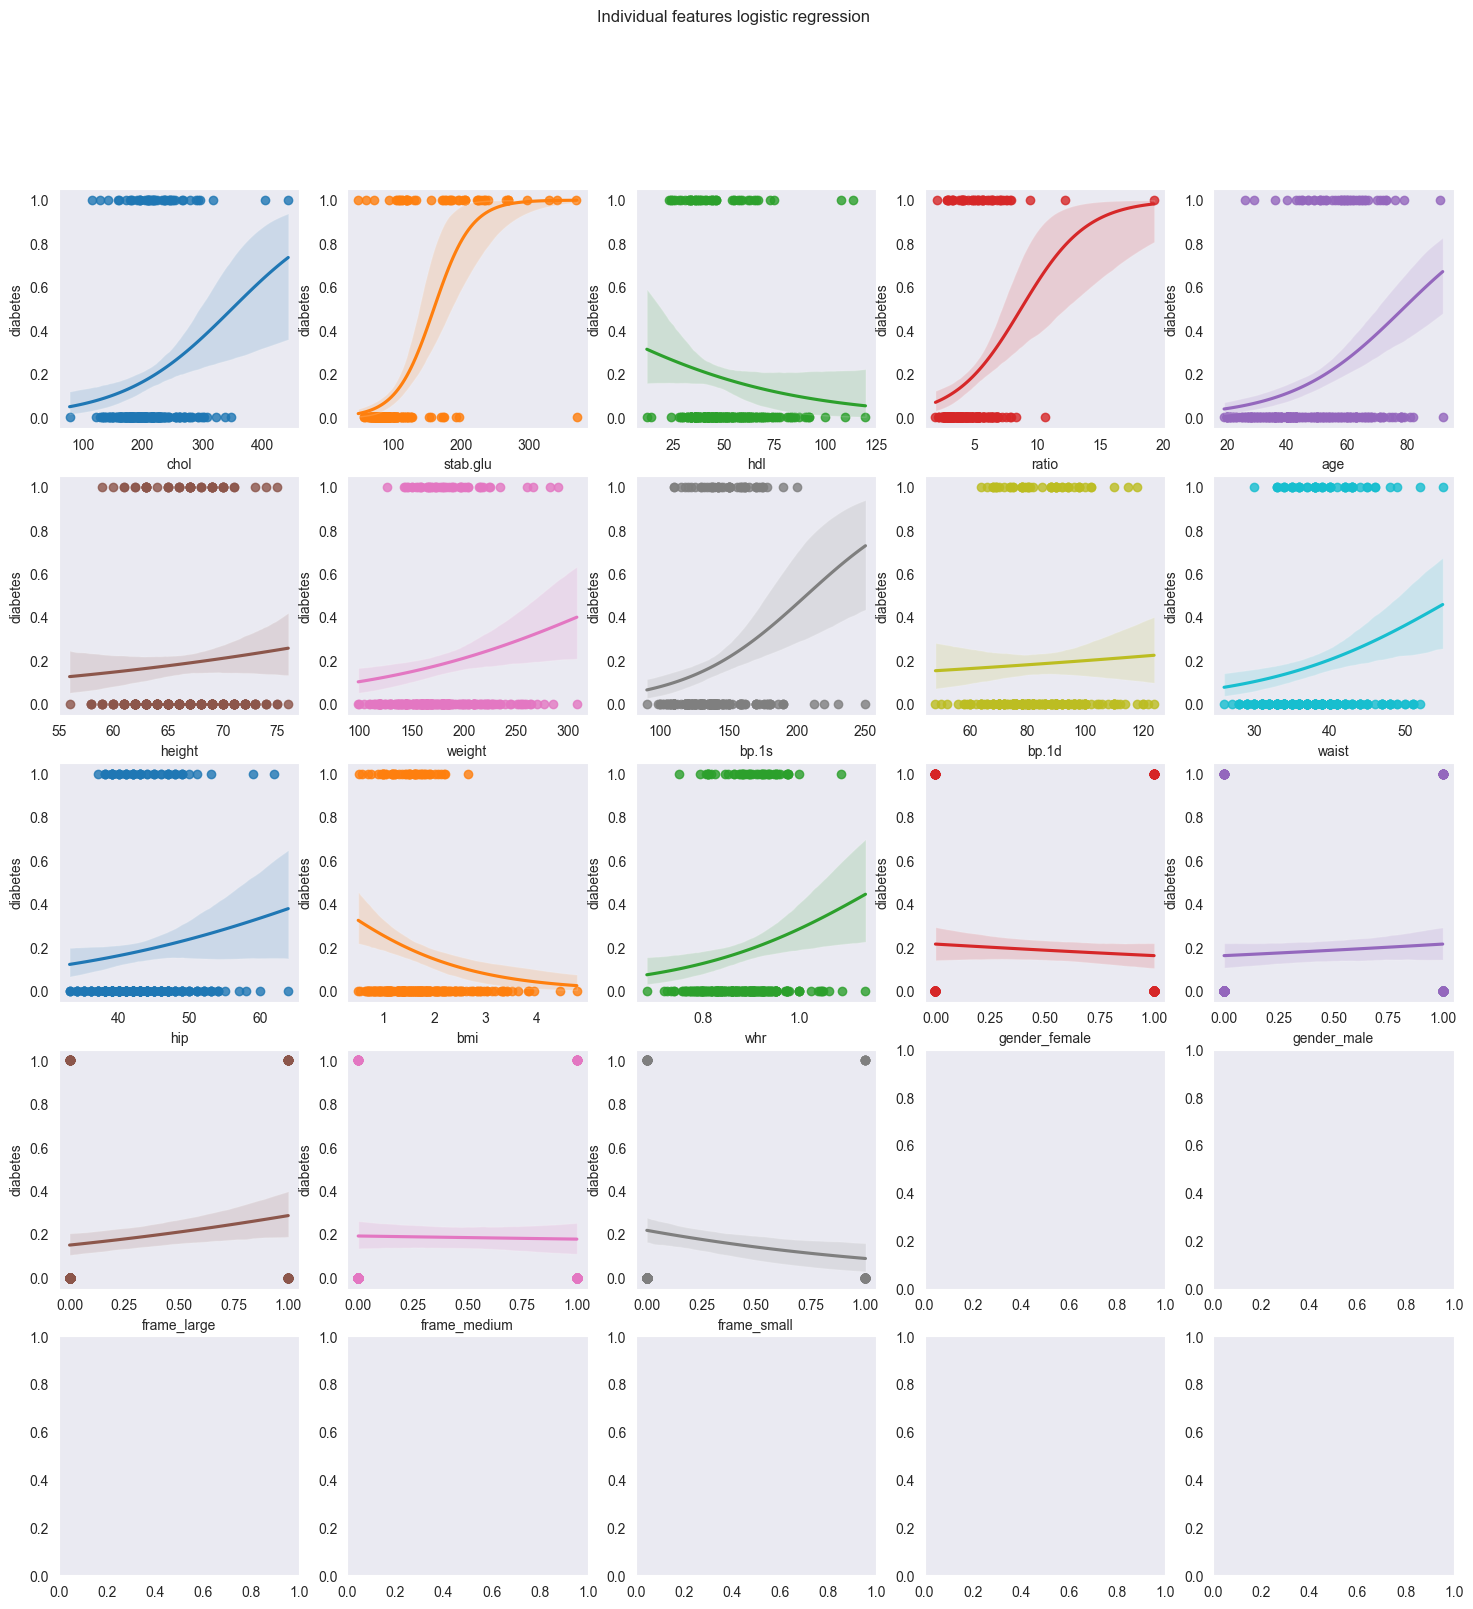

In [271]:
feat_len = len(features);
size = int(np.ceil(np.sqrt(feat_len)))
cols = sns.color_palette()

fig, axs = plt.subplots(size, size, figsize=(18,18))
fig.suptitle("Individual features logistic regression")
i = 0
for r in range(0, size):
  for c in range(0, size):
    if i < feat_len:
      rgb = [1, 0, 0]
      random.shuffle(rgb)
      sns.regplot(x=X_train[features[i]], y=y_train, logistic=True, ax=axs[r, c], color=cols[i % len(cols)])
    i = i + 1

From the plots above the `stab.glu` and the `ratio` columns appear to be fit the model the best with `bpd.1`, `gender` and `frame` having minimal affect on diabetes. `bmi` has a similar correlation to `weight` however `waist` has a better confidence interval for its correlation than `whr`.

Then the regression model was fitted with `1000` iterations using the training data split.

In [272]:
reg = LogisticRegression(max_iter=1000, random_state=0)
reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

Once fitted the model can be used on the training data to predict if the patient has diabetes or not and the results can be viewed in a confusion matrix.

[Text(0, 0.5, 'No diabetes'), Text(0, 1.5, 'Has diabetes')]

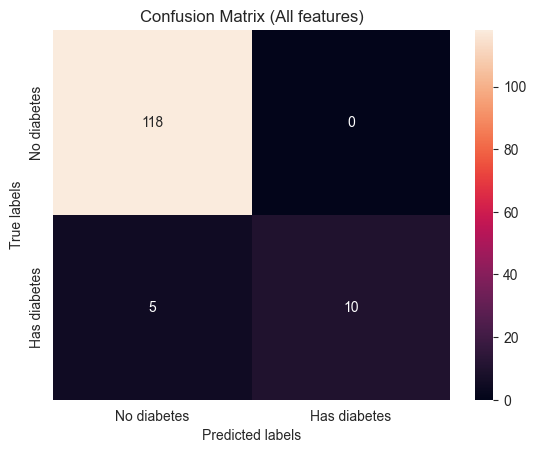

In [273]:
y_pred = reg.predict(X_test)

conf = metrics.confusion_matrix(y_test, y_pred)

labels = ["No diabetes", "Has diabetes"]
ax = plt.subplot()
sns.heatmap(pd.DataFrame(conf), annot=True, fmt="g", ax=ax)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix (All features)")
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Model Evaulation

The model appears to generalize very well as the training set only yielded `5` incorrect values out of `133` values (`96%` accuracy) in the test split having not been trained on them. 

From the individual regression contributions charts above the model"s feature list can be condensed. As `bmi` appeared to have minimal improvement over using `weight`, `height` and `bmi` were dropped and similarly for `whr`, `whr` and `hip` were dropped in favor of `waist`. `chol` and `hdl` were dropped since the `ratio` of cholesterol appears to be better correlated to diabetes than them individually and `bd.1d`, `frame` and `gender` for their weak correlation.

[Text(0, 0.5, 'No diabetes'), Text(0, 1.5, 'Has diabetes')]

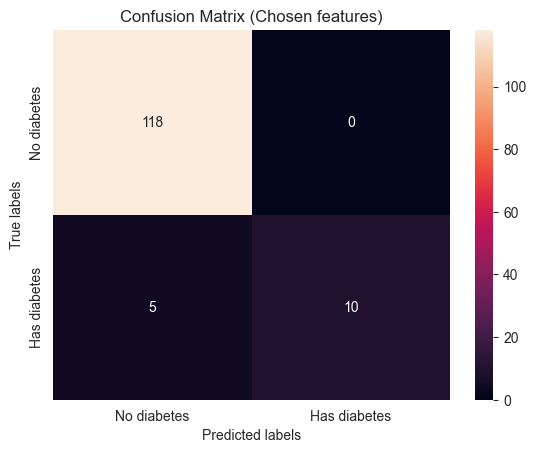

In [286]:
features = ["stab.glu", "ratio", "age", "bp.1s", "bmi", "waist"]

X = df_pre[features]
y = df["glyhb"].map(lambda x: 1 if x > 6.5 else 0).to_frame("diabetes")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

reg = LogisticRegression(max_iter=1000, random_state=0)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

conf = metrics.confusion_matrix(y_test, y_pred)

labels = ["No diabetes", "Has diabetes"]
ax = plt.subplot()
sns.heatmap(pd.DataFrame(conf), annot=True, fmt="g", ax=ax)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix (Chosen features)")
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

The confusion matrix denotes that the model performed with an accuracy of `96%`.

As indicated above a similar confusion matrix of results was achieved with less features indicating the lack of their contribution to determining if a patient had diabetes or not. This results reflects the intituition of the chosen features:

- `stab.glu` reflecting the glucose concentration which when high points to diabetes 
- `ratio` for for ratio of total to good cholesterol which when high points to diabetes 
- `age` for which the risk of diabetes increases when older
- `bp.1s` the upper limit of blood pressure which when higher reflects a higher chance in getting diabetes
- `bmi` indicating obesity when large pointing to greater diabetes risk
- `waist` similarly for weight when large indicates obesity points to greater diabetes risk

# Optimization

The issue with using logistic regression as a whole is overfitting to the dataset which reduces its generalization to classify unseen data. To combat this cross validation was used to tune the feature selection and for the test and training data splits.

In [282]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
reg = LogisticRegression(max_iter=1000, random_state=0)
results = cross_val_score(reg, X, y.values.ravel(), cv=kfold)

print(f"Accuracy: {results.mean() * 100} ({results.std() * 100})")

Accuracy: 92.01829268292683 (4.017681955143154)


Using cross validation training test splitting we achieved `92%` accuracy compared to the `96%` accuracy without overfitting however this `92%` is an average accuracy across all folds indicating with less overfitting indicating a more reliable result.

Grid search cross validation was also used to select which hyperparameters for logistic regression performed the best.

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
reg = LogisticRegression(max_iter=1000, random_state=0)

parameters = {
    "penalty" : ["l1","l2"], 
    "C"       : np.logspace(-3,3,7),
    "solver"  : ["newton-cg", "lbfgs", "liblinear"],
}
clf = GridSearchCV(reg, param_grid=parameters, scoring="accuracy", cv=10)

clf.fit(X_train, y_train)

print(f"Tuned Hyperparameters: {clf.best_params_}")
print(f"Accuracy: {clf.best_score_}")

Tuned Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.9111111111111111


Using grid search the accuracy achieved was however `91%` on average compared to the `96%`. Nonetheless these tuned hyperparameters were used to create a new model to fit the data.

[Text(0, 0.5, 'No diabetes'), Text(0, 1.5, 'Has diabetes')]

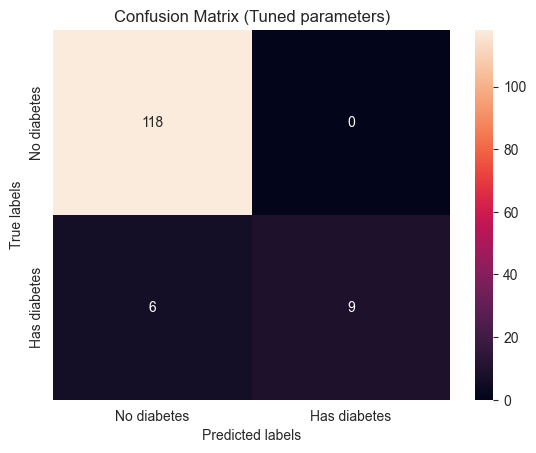

In [287]:
reg = LogisticRegression(max_iter=1000, C=0.1, penalty="l1", solver="liblinear", random_state=0)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

conf = metrics.confusion_matrix(y_test, y_pred)

labels = ["No diabetes", "Has diabetes"]
ax = plt.subplot()
sns.heatmap(pd.DataFrame(conf), annot=True, fmt="g", ax=ax)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix (Tuned parameters)")
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

The accuracy of the model is still `127` correct out of `133` still yielding `93%` accuracy.